In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
aug_train_processed['Location'][:10]


0    Location1
1    Location1
2    Location1
3    Location1
4    Location1
5    Location1
6    Location1
7    Location1
8    Location1
9    Location1
Name: Location, dtype: object

In [8]:
aug_train_processed.head(10)


,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24,hour,month,hour_sin,hour_cos,month_sin,month_cos
0,2017-01-03 00:00:00,36.1,96.0,35.1,0.146796,0.198739,72,92,0.169148,0.182544,...,0.172166,0.105998,0.174241,0.156923,0,1,0.500000,1.000000,0.75,0.933013
1,2017-01-03 01:00:00,36.6,97.0,35.8,0.140852,0.204747,113,118,0.189192,0.159689,...,0.175407,0.103880,0.177464,0.154968,1,1,0.629410,0.982963,0.75,0.933013
2,2017-01-03 02:00:00,36.6,99.0,36.2,0.070017,0.120637,111,135,0.159126,0.136833,...,0.176518,0.098117,0.181255,0.144895,2,1,0.750000,0.933013,0.75,0.933013
3,2017-01-03 03:00:00,36.6,99.0,36.4,0.080915,0.086357,30,83,0.085632,0.113977,...,0.176027,0.101345,0.183909,0.127052,3,1,0.853553,0.853553,0.75,0.933013
4,2017-01-03 04:00:00,36.3,100.0,36.2,0.059119,0.058439,20,43,0.088972,0.091121,...,0.170928,0.125493,0.182203,0.134628,4,1,0.933013,0.750000,0.75,0.933013
5,2017-01-03 05:00:00,36.5,100.0,36.4,0.090326,0.100493,56,67,0.082291,0.086772,...,0.165884,0.133873,0.179170,0.146183,5,1,0.982963,0.629410,0.75,0.933013
6,2017-01-03 06:00:00,35.9,100.0,35.8,0.084382,0.137247,73,80,0.129060,0.100930,...,0.162314,0.134524,0.178412,0.147797,6,1,1.000000,0.500000,0.75,0.933013
7,2017-01-03 07:00:00,36.3,100.0,36.2,0.090326,0.122758,56,80,0.105676,0.115089,...,0.157234,0.134419,0.176137,0.153628,7,1,0.982963,0.370590,0.75,0.933013
8,2017-01-03 08:00:00,36.6,100.0,36.5,0.125496,0.164106,61,72,0.135741,0.129248,...,0.153100,0.125923,0.173673,0.155477,8,1,0.933013,0.250000,0.75,0.933013
9,2017-01-03 09:00:00,37.4,99.0,37.2,0.125001,0.174001,53,70,0.145763,0.143406,...,0.151079,0.122575,0.170450,0.154712,9,1,0.853553,0.146447,0.75,0.933013


In [9]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
# ------------------ TimeMoE Model ------------------

class Expert(nn.Module):
    def __init__(self, n_features, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class GatingNetwork(nn.Module):
    def __init__(self, n_features, n_experts):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, n_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class TimeMoE(nn.Module):
    def __init__(self, n_features, d_model=64, n_experts=4):
        super().__init__()
        self.experts = nn.ModuleList([Expert(n_features, d_model) for _ in range(n_experts)])
        self.gate = GatingNetwork(n_features, n_experts)
        self.final = nn.Linear(d_model, 1)

    def forward(self, x):
        batch_size, seq_len, n_features = x.shape
        x_flat = x[:, -1, :]  # Use last timestep for gating
        gate_weights = self.gate(x_flat)

        expert_outputs = torch.stack([expert(x_flat) for expert in self.experts], dim=1)
        gated_output = torch.sum(gate_weights.unsqueeze(-1) * expert_outputs, dim=1)

        out = self.final(gated_output)
        return out.squeeze()

In [12]:
# ------------------ Dataset Preparation ------------------

def create_autoregressive_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

In [13]:

# ------------------ Training Function ------------------

def train_timemoe(X_train, y_train, features, seq_len, epochs=10, batch_size=32):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)

    X_seq, y_seq = create_autoregressive_sequences(X_train_scaled, y_train, seq_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = TimeMoE(len(features))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    return model, scaler

In [14]:
# ------------------ Evaluation Function ------------------

def evaluate_timemoe(model, scaler, X_test, y_test, y_train_org, features, seq_len, time_index=None, start_point=0, end_point=None):
    # Subset X_test and y_test before scaling
    X_test_sub = X_test.iloc[start_point:end_point].reset_index(drop=True)
    y_test_sub = y_test.iloc[start_point:end_point].reset_index(drop=True)

    # Scale features only on subset
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_sub), columns=features)
    X_seq, y_seq = create_autoregressive_sequences(X_test_scaled, y_test_sub, seq_len)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).numpy()

    # Inverse scaling target
    y_scaler = StandardScaler()
    y_scaler.fit(y_train_org.values.reshape(-1, 1))  # use full original train target

    y_seq_inv = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
    preds_inv = y_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()

    # Metrics
    mse = mean_squared_error(y_seq_inv, preds_inv)
    mae = mean_absolute_error(y_seq_inv, preds_inv)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Plotting
    if time_index is not None:
        plot_range = time_index[start_point + seq_len : end_point]
    else:
        plot_range = range(len(y_seq_inv))

    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, y_seq_inv, label='Actual', color='black')
    plt.plot(plot_range, preds_inv, label='Forecast', color='red', linestyle='--')
    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TimeMoE Forecast vs Actual (Inverse Scaled)")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



In [15]:
seq_len = 24
forecast_horizon = 12  # Not needed for direct prediction

X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

X_test = org_test_processed[features]
y_test = org_test_processed[target]

In [16]:
epoch = 100

In [19]:
print("Training TimeMoE...")
model_timemoe, scaler_timemoe = train_timemoe(X_train_org, y_train_org, features, seq_len, epochs=epoch)


Training TimeMoE...


Epoch 1: 100%|██████████| 4377/4377 [00:05<00:00, 757.67it/s]


Epoch 1, Loss: 0.0013


Epoch 2: 100%|██████████| 4377/4377 [00:06<00:00, 693.38it/s]


Epoch 2, Loss: 0.0006


Epoch 3: 100%|██████████| 4377/4377 [00:06<00:00, 711.54it/s]


Epoch 3, Loss: 0.0004


Epoch 4: 100%|██████████| 4377/4377 [00:05<00:00, 732.92it/s]


Epoch 4, Loss: 0.0004


Epoch 5: 100%|██████████| 4377/4377 [00:05<00:00, 772.11it/s]


Epoch 5, Loss: 0.0003


Epoch 6: 100%|██████████| 4377/4377 [00:05<00:00, 795.95it/s]


Epoch 6, Loss: 0.0003


Epoch 7: 100%|██████████| 4377/4377 [00:05<00:00, 756.30it/s]


Epoch 7, Loss: 0.0003


Epoch 8: 100%|██████████| 4377/4377 [00:05<00:00, 740.24it/s]


Epoch 8, Loss: 0.0003


Epoch 9: 100%|██████████| 4377/4377 [00:05<00:00, 734.74it/s]


Epoch 9, Loss: 0.0002


Epoch 10: 100%|██████████| 4377/4377 [00:06<00:00, 718.38it/s]

Epoch 10, Loss: 0.0002


In [20]:
import joblib

# Define file paths
filename = '../weights'
model_path = "TimeMOE_org_model.pth"
scaler_path = "scaler_TimeMOE_org.pkl"

# Save model weights
torch.save(model_timemoe.state_dict(), f'{filename}/{model_path}')

# Save scaler using joblib (more robust for sklearn objects)
joblib.dump(scaler_timemoe, f'{filename}/{scaler_path}')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.


In [17]:

print("Training Time-LLM...")
model_timemoe_aug, scaler_time_aug = train_timemoe(X_train_aug, y_train_aug, features, seq_len, epochs=epoch)


Training Time-LLM...


Epoch 1: 100%|██████████| 26262/26262 [01:48<00:00, 243.08it/s]


Epoch 1, Loss: 0.0007


Epoch 2: 100%|██████████| 26262/26262 [00:40<00:00, 644.40it/s]


Epoch 2, Loss: 0.0002


Epoch 3: 100%|██████████| 26262/26262 [00:37<00:00, 697.32it/s]


Epoch 3, Loss: 0.0002


Epoch 4: 100%|██████████| 26262/26262 [00:39<00:00, 672.35it/s]


Epoch 4, Loss: 0.0002


Epoch 5: 100%|██████████| 26262/26262 [00:39<00:00, 670.85it/s]


Epoch 5, Loss: 0.0001


Epoch 6: 100%|██████████| 26262/26262 [00:35<00:00, 747.10it/s]


Epoch 6, Loss: 0.0001


Epoch 7: 100%|██████████| 26262/26262 [00:36<00:00, 721.31it/s]


Epoch 7, Loss: 0.0001


Epoch 8: 100%|██████████| 26262/26262 [00:34<00:00, 759.43it/s]


Epoch 8, Loss: 0.0001


Epoch 9: 100%|██████████| 26262/26262 [00:35<00:00, 745.53it/s]


Epoch 9, Loss: 0.0001


Epoch 10: 100%|██████████| 26262/26262 [00:39<00:00, 665.24it/s]


Epoch 10, Loss: 0.0001


Epoch 11: 100%|██████████| 26262/26262 [00:34<00:00, 759.74it/s]


Epoch 11, Loss: 0.0001


Epoch 12: 100%|██████████| 26262/26262 [00:36<00:00, 724.44it/s]


Epoch 12, Loss: 0.0001


Epoch 13: 100%|██████████| 26262/26262 [00:34<00:00, 767.73it/s]


Epoch 13, Loss: 0.0001


Epoch 14: 100%|██████████| 26262/26262 [00:34<00:00, 760.86it/s]


Epoch 14, Loss: 0.0001


Epoch 15: 100%|██████████| 26262/26262 [00:34<00:00, 766.46it/s]


Epoch 15, Loss: 0.0001


Epoch 16: 100%|██████████| 26262/26262 [00:34<00:00, 772.01it/s]


Epoch 16, Loss: 0.0001


Epoch 17: 100%|██████████| 26262/26262 [00:33<00:00, 772.56it/s]


Epoch 17, Loss: 0.0001


Epoch 18: 100%|██████████| 26262/26262 [00:34<00:00, 769.91it/s]


Epoch 18, Loss: 0.0001


Epoch 19: 100%|██████████| 26262/26262 [00:35<00:00, 740.45it/s]


Epoch 19, Loss: 0.0001


Epoch 20: 100%|██████████| 26262/26262 [00:37<00:00, 691.89it/s]


Epoch 20, Loss: 0.0001


Epoch 21: 100%|██████████| 26262/26262 [00:34<00:00, 771.76it/s]


Epoch 21, Loss: 0.0001


Epoch 22: 100%|██████████| 26262/26262 [00:34<00:00, 757.54it/s]


Epoch 22, Loss: 0.0001


Epoch 23: 100%|██████████| 26262/26262 [00:36<00:00, 722.58it/s]


Epoch 23, Loss: 0.0001


Epoch 24: 100%|██████████| 26262/26262 [00:35<00:00, 733.20it/s]


Epoch 24, Loss: 0.0001


Epoch 25: 100%|██████████| 26262/26262 [00:34<00:00, 763.41it/s]


Epoch 25, Loss: 0.0001


Epoch 26: 100%|██████████| 26262/26262 [00:34<00:00, 768.56it/s]


Epoch 26, Loss: 0.0001


Epoch 27: 100%|██████████| 26262/26262 [00:34<00:00, 769.64it/s]


Epoch 27, Loss: 0.0001


Epoch 28: 100%|██████████| 26262/26262 [00:34<00:00, 767.64it/s]


Epoch 28, Loss: 0.0000


Epoch 29: 100%|██████████| 26262/26262 [00:34<00:00, 754.99it/s]


Epoch 29, Loss: 0.0000


Epoch 30: 100%|██████████| 26262/26262 [00:48<00:00, 545.99it/s]


Epoch 30, Loss: 0.0000


Epoch 31: 100%|██████████| 26262/26262 [00:38<00:00, 680.07it/s]


Epoch 31, Loss: 0.0000


Epoch 32: 100%|██████████| 26262/26262 [00:47<00:00, 552.98it/s]


Epoch 32, Loss: 0.0000


Epoch 33: 100%|██████████| 26262/26262 [00:41<00:00, 636.11it/s]


Epoch 33, Loss: 0.0000


Epoch 34: 100%|██████████| 26262/26262 [00:50<00:00, 514.97it/s]


Epoch 34, Loss: 0.0000


Epoch 35: 100%|██████████| 26262/26262 [00:58<00:00, 450.17it/s]


Epoch 35, Loss: 0.0000


Epoch 36: 100%|██████████| 26262/26262 [00:50<00:00, 519.90it/s]


Epoch 36, Loss: 0.0000


Epoch 37: 100%|██████████| 26262/26262 [00:41<00:00, 636.40it/s]


Epoch 37, Loss: 0.0000


Epoch 38: 100%|██████████| 26262/26262 [00:51<00:00, 511.22it/s]


Epoch 38, Loss: 0.0000


Epoch 39: 100%|██████████| 26262/26262 [00:45<00:00, 573.24it/s]


Epoch 39, Loss: 0.0000


Epoch 40: 100%|██████████| 26262/26262 [00:41<00:00, 629.23it/s]


Epoch 40, Loss: 0.0000


Epoch 41: 100%|██████████| 26262/26262 [00:43<00:00, 601.59it/s]


Epoch 41, Loss: 0.0000


Epoch 42: 100%|██████████| 26262/26262 [00:46<00:00, 567.28it/s]


Epoch 42, Loss: 0.0000


Epoch 43: 100%|██████████| 26262/26262 [00:47<00:00, 549.09it/s]


Epoch 43, Loss: 0.0000


Epoch 44: 100%|██████████| 26262/26262 [00:50<00:00, 524.65it/s]


Epoch 44, Loss: 0.0000


Epoch 45: 100%|██████████| 26262/26262 [00:51<00:00, 509.57it/s]


Epoch 45, Loss: 0.0000


Epoch 46: 100%|██████████| 26262/26262 [00:39<00:00, 663.21it/s]


Epoch 46, Loss: 0.0000


Epoch 47: 100%|██████████| 26262/26262 [00:38<00:00, 677.81it/s]


Epoch 47, Loss: 0.0000


Epoch 48: 100%|██████████| 26262/26262 [00:37<00:00, 706.20it/s]


Epoch 48, Loss: 0.0000


Epoch 49: 100%|██████████| 26262/26262 [00:39<00:00, 665.91it/s]


Epoch 49, Loss: 0.0000


Epoch 50: 100%|██████████| 26262/26262 [00:37<00:00, 692.45it/s]


Epoch 50, Loss: 0.0000


Epoch 51: 100%|██████████| 26262/26262 [00:42<00:00, 613.82it/s]


Epoch 51, Loss: 0.0000


Epoch 52: 100%|██████████| 26262/26262 [00:46<00:00, 561.35it/s]


Epoch 52, Loss: 0.0000


Epoch 53: 100%|██████████| 26262/26262 [00:46<00:00, 564.05it/s]


Epoch 53, Loss: 0.0000


Epoch 54: 100%|██████████| 26262/26262 [00:38<00:00, 676.93it/s]


Epoch 54, Loss: 0.0000


Epoch 55: 100%|██████████| 26262/26262 [00:37<00:00, 697.58it/s]


Epoch 55, Loss: 0.0000


Epoch 56: 100%|██████████| 26262/26262 [00:37<00:00, 709.37it/s]


Epoch 56, Loss: 0.0000


Epoch 57: 100%|██████████| 26262/26262 [00:38<00:00, 676.33it/s]


Epoch 57, Loss: 0.0000


Epoch 58: 100%|██████████| 26262/26262 [00:37<00:00, 708.55it/s]


Epoch 58, Loss: 0.0000


Epoch 59: 100%|██████████| 26262/26262 [00:37<00:00, 699.90it/s]


Epoch 59, Loss: 0.0000


Epoch 60: 100%|██████████| 26262/26262 [00:43<00:00, 597.25it/s]


Epoch 60, Loss: 0.0000


Epoch 61: 100%|██████████| 26262/26262 [00:38<00:00, 690.96it/s]


Epoch 61, Loss: 0.0000


Epoch 62: 100%|██████████| 26262/26262 [00:36<00:00, 710.84it/s]


Epoch 62, Loss: 0.0000


Epoch 63: 100%|██████████| 26262/26262 [00:36<00:00, 714.38it/s]


Epoch 63, Loss: 0.0000


Epoch 64: 100%|██████████| 26262/26262 [00:36<00:00, 711.37it/s]


Epoch 64, Loss: 0.0000


Epoch 65: 100%|██████████| 26262/26262 [00:36<00:00, 713.21it/s]


Epoch 65, Loss: 0.0000


Epoch 66: 100%|██████████| 26262/26262 [00:36<00:00, 719.50it/s]


Epoch 66, Loss: 0.0000


Epoch 67: 100%|██████████| 26262/26262 [00:37<00:00, 699.86it/s]


Epoch 67, Loss: 0.0000


Epoch 68: 100%|██████████| 26262/26262 [00:37<00:00, 697.32it/s]


Epoch 68, Loss: 0.0000


Epoch 69: 100%|██████████| 26262/26262 [00:38<00:00, 676.21it/s]


Epoch 69, Loss: 0.0000


Epoch 70: 100%|██████████| 26262/26262 [00:39<00:00, 660.84it/s]


Epoch 70, Loss: 0.0000


Epoch 71: 100%|██████████| 26262/26262 [00:38<00:00, 677.62it/s]


Epoch 71, Loss: 0.0000


Epoch 72: 100%|██████████| 26262/26262 [00:37<00:00, 693.38it/s]


Epoch 72, Loss: 0.0000


Epoch 73: 100%|██████████| 26262/26262 [00:43<00:00, 608.28it/s]


Epoch 73, Loss: 0.0000


Epoch 74: 100%|██████████| 26262/26262 [00:39<00:00, 672.43it/s]


Epoch 74, Loss: 0.0000


Epoch 75: 100%|██████████| 26262/26262 [00:38<00:00, 688.86it/s]


Epoch 75, Loss: 0.0000


Epoch 76: 100%|██████████| 26262/26262 [00:38<00:00, 680.60it/s]


Epoch 76, Loss: 0.0000


Epoch 77: 100%|██████████| 26262/26262 [00:38<00:00, 679.40it/s]


Epoch 77, Loss: 0.0000


Epoch 78: 100%|██████████| 26262/26262 [00:38<00:00, 678.93it/s]


Epoch 78, Loss: 0.0000


Epoch 79: 100%|██████████| 26262/26262 [00:38<00:00, 680.16it/s]


Epoch 79, Loss: 0.0000


Epoch 80: 100%|██████████| 26262/26262 [00:37<00:00, 705.76it/s]


Epoch 80, Loss: 0.0000


Epoch 81: 100%|██████████| 26262/26262 [00:37<00:00, 700.88it/s]


Epoch 81, Loss: 0.0000


Epoch 82: 100%|██████████| 26262/26262 [00:38<00:00, 676.54it/s]


Epoch 82, Loss: 0.0000


Epoch 83: 100%|██████████| 26262/26262 [00:37<00:00, 706.17it/s]


Epoch 83, Loss: 0.0000


Epoch 84: 100%|██████████| 26262/26262 [00:37<00:00, 706.79it/s]


Epoch 84, Loss: 0.0000


Epoch 85: 100%|██████████| 26262/26262 [00:38<00:00, 679.94it/s]


Epoch 85, Loss: 0.0000


Epoch 86: 100%|██████████| 26262/26262 [00:44<00:00, 595.27it/s]


Epoch 86, Loss: 0.0000


Epoch 87: 100%|██████████| 26262/26262 [00:39<00:00, 664.59it/s]


Epoch 87, Loss: 0.0000


Epoch 88: 100%|██████████| 26262/26262 [00:49<00:00, 529.00it/s]


Epoch 88, Loss: 0.0000


Epoch 89: 100%|██████████| 26262/26262 [00:38<00:00, 687.61it/s]


Epoch 89, Loss: 0.0000


Epoch 90: 100%|██████████| 26262/26262 [00:36<00:00, 710.27it/s]


Epoch 90, Loss: 0.0000


Epoch 91: 100%|██████████| 26262/26262 [00:37<00:00, 707.34it/s]


Epoch 91, Loss: 0.0000


Epoch 92: 100%|██████████| 26262/26262 [00:38<00:00, 680.53it/s]


Epoch 92, Loss: 0.0000


Epoch 93: 100%|██████████| 26262/26262 [00:38<00:00, 680.37it/s]


Epoch 93, Loss: 0.0000


Epoch 94: 100%|██████████| 26262/26262 [00:37<00:00, 705.91it/s]


Epoch 94, Loss: 0.0000


Epoch 95: 100%|██████████| 26262/26262 [00:37<00:00, 695.96it/s]


Epoch 95, Loss: 0.0000


Epoch 96: 100%|██████████| 26262/26262 [00:37<00:00, 700.89it/s]


Epoch 96, Loss: 0.0000


Epoch 97: 100%|██████████| 26262/26262 [00:37<00:00, 709.34it/s]


Epoch 97, Loss: 0.0000


Epoch 98: 100%|██████████| 26262/26262 [00:37<00:00, 703.25it/s]


Epoch 98, Loss: 0.0000


Epoch 99: 100%|██████████| 26262/26262 [00:37<00:00, 707.30it/s]


Epoch 99, Loss: 0.0000


Epoch 100: 100%|██████████| 26262/26262 [00:38<00:00, 689.84it/s]


Epoch 100, Loss: 0.0000


In [19]:
import joblib

# Define file paths
filename = '../weights'
model_path = "TimeMOE_aug_model.pth"
scaler_path = "scaler_TimeMOE_aug.pkl"

# Save model weights
torch.save(model_timemoe_aug.state_dict(), f'{filename}/{model_path}')

# Save scaler using joblib (more robust for sklearn objects)
joblib.dump(scaler_time_aug, f'{filename}/{scaler_path}')

print("Model and scaler saved successfully.")

Model and scaler saved successfully.



Evaluating TimeMoE...
Test MSE: 0.0000, MAE: 0.0014, RMSE: 0.0027


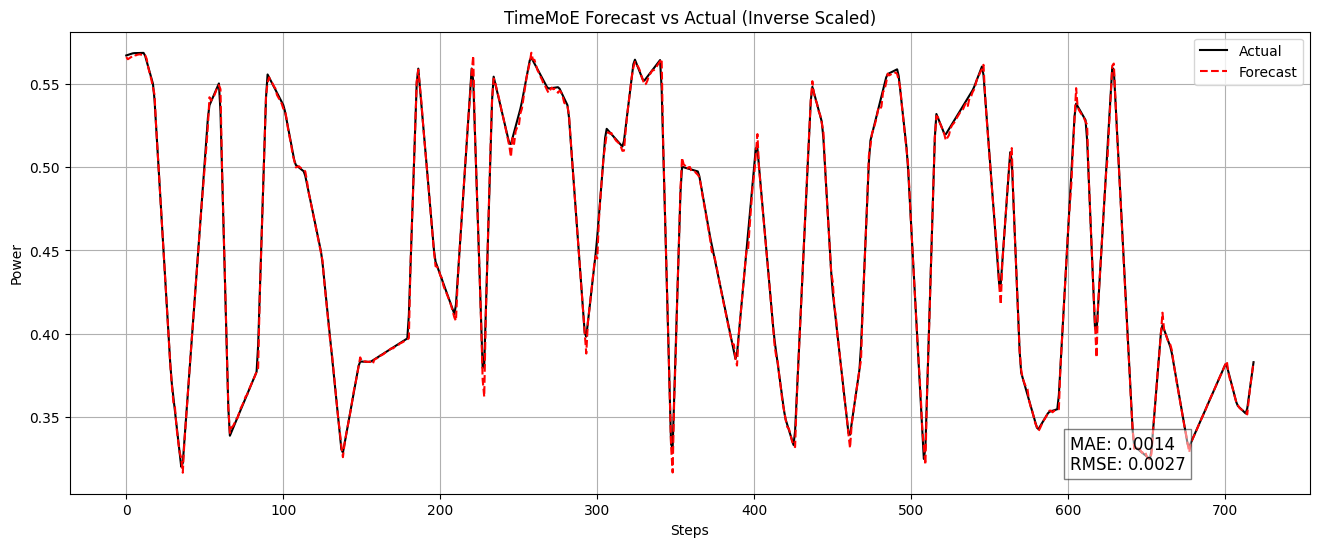

Test MSE: 0.0000, MAE: 0.0012, RMSE: 0.0023


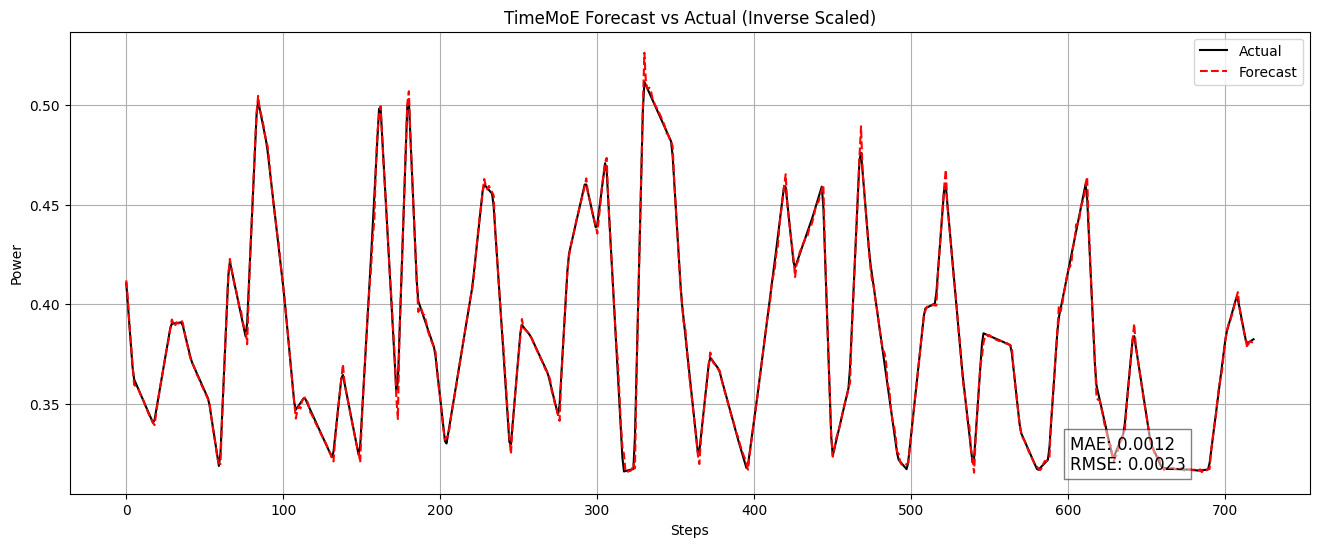

Test MSE: 0.0000, MAE: 0.0019, RMSE: 0.0036


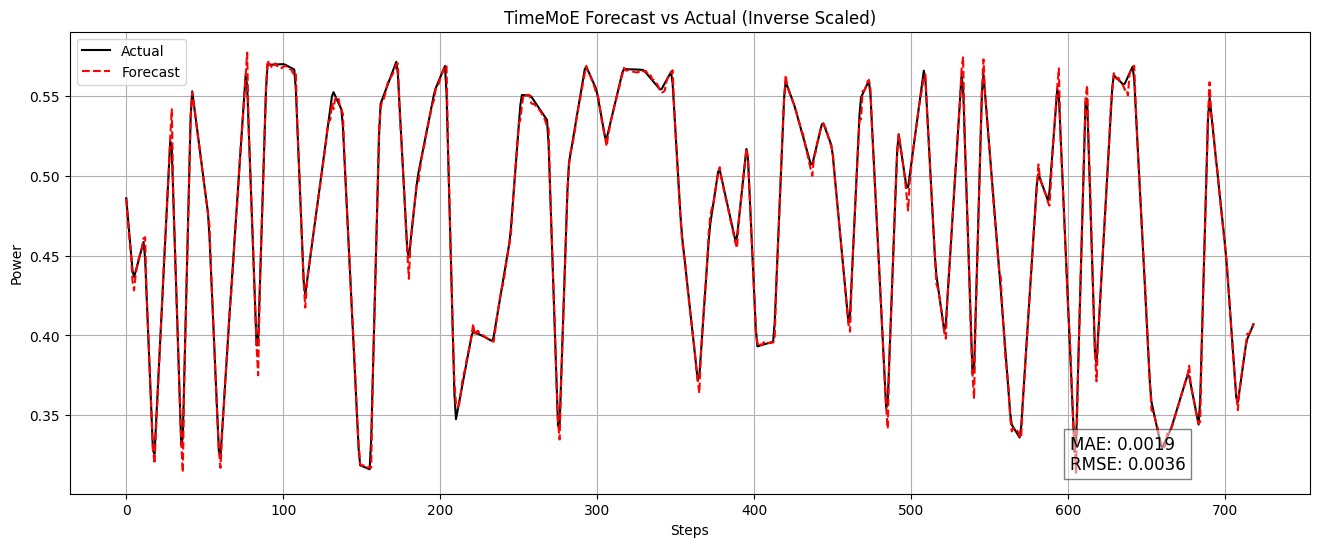

Test MSE: 0.0000, MAE: 0.0013, RMSE: 0.0025


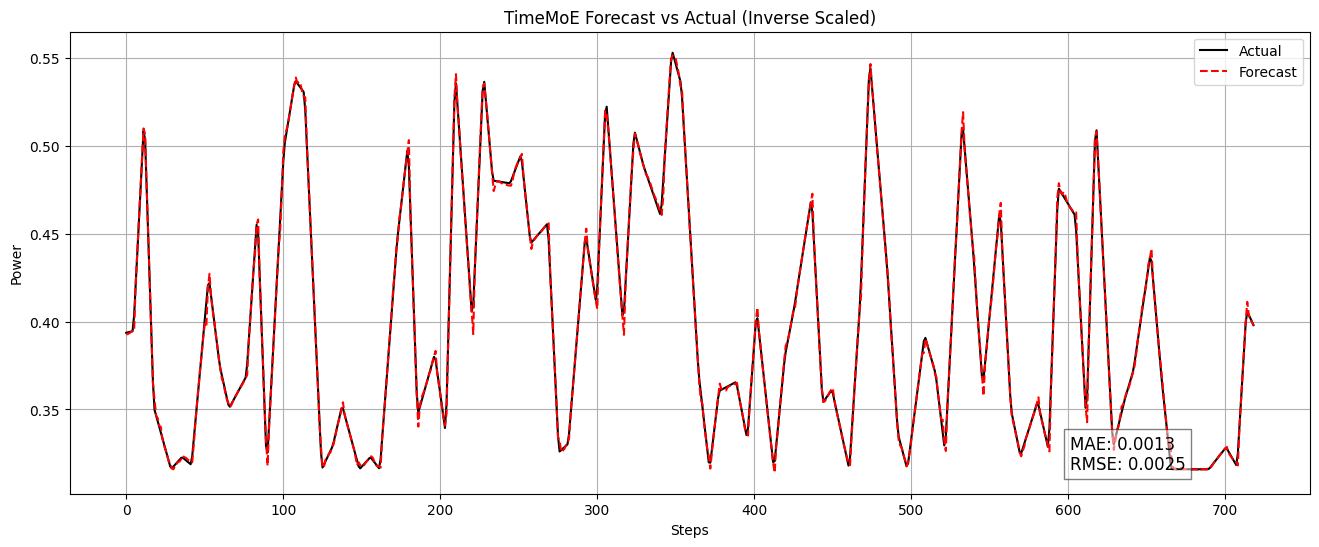

In [18]:
print("\nEvaluating TimeMoE...")

evaluate_timemoe(model_timemoe_aug, scaler_time_aug, X_test, y_test, y_train_aug, features, seq_len, start_point=7991, end_point=8734)
evaluate_timemoe(model_timemoe_aug, scaler_time_aug, X_test, y_test, y_train_aug, features, seq_len,  start_point=16726, end_point=17469)
evaluate_timemoe(model_timemoe_aug, scaler_time_aug, X_test, y_test, y_train_aug, features, seq_len, start_point=25461, end_point=26204)
evaluate_timemoe(model_timemoe_aug, scaler_time_aug, X_test, y_test, y_train_aug, features, seq_len, start_point=34196, end_point=34939)




Evaluating TimeMoE...
Test MSE: 0.0001, MAE: 0.0048, RMSE: 0.0073


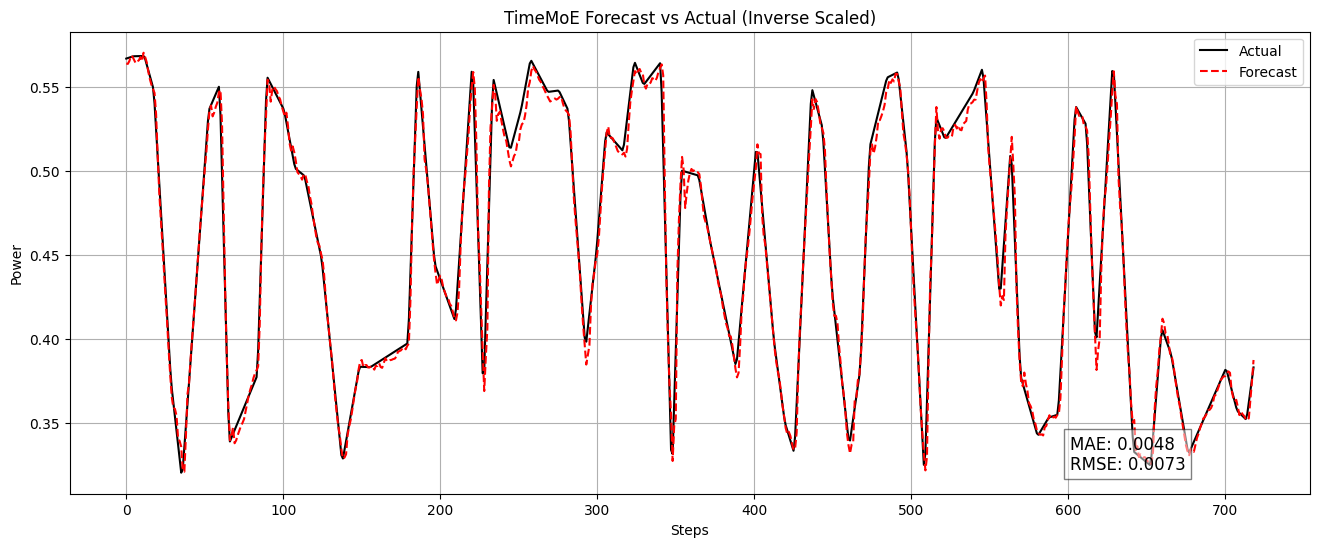

Test MSE: 0.0000, MAE: 0.0041, RMSE: 0.0058


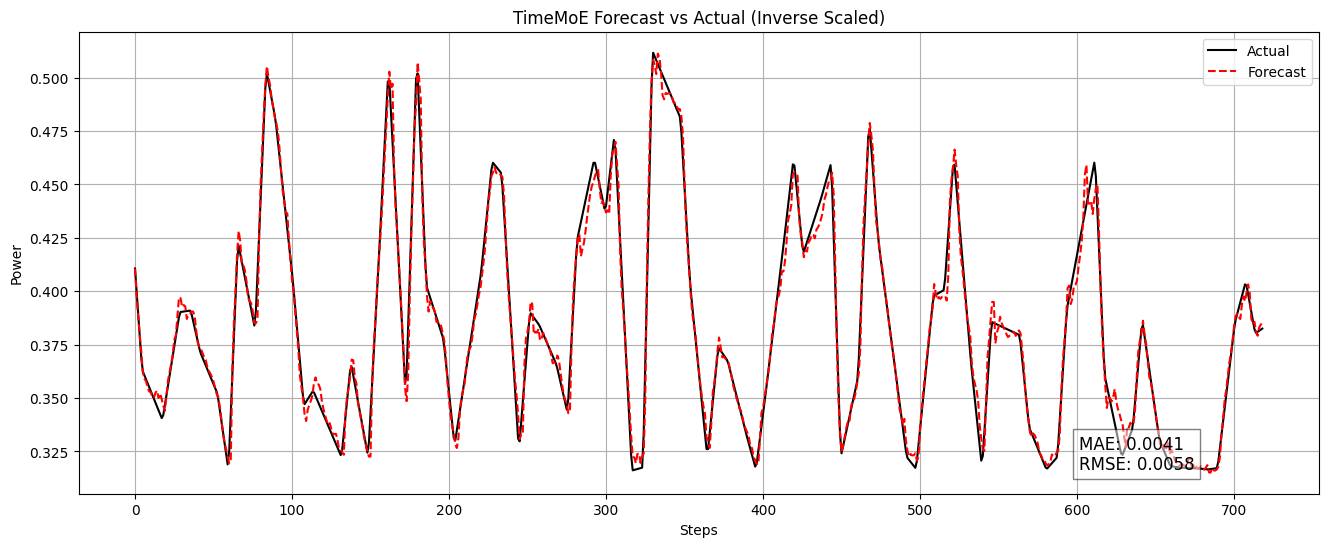

Test MSE: 0.0001, MAE: 0.0071, RMSE: 0.0097


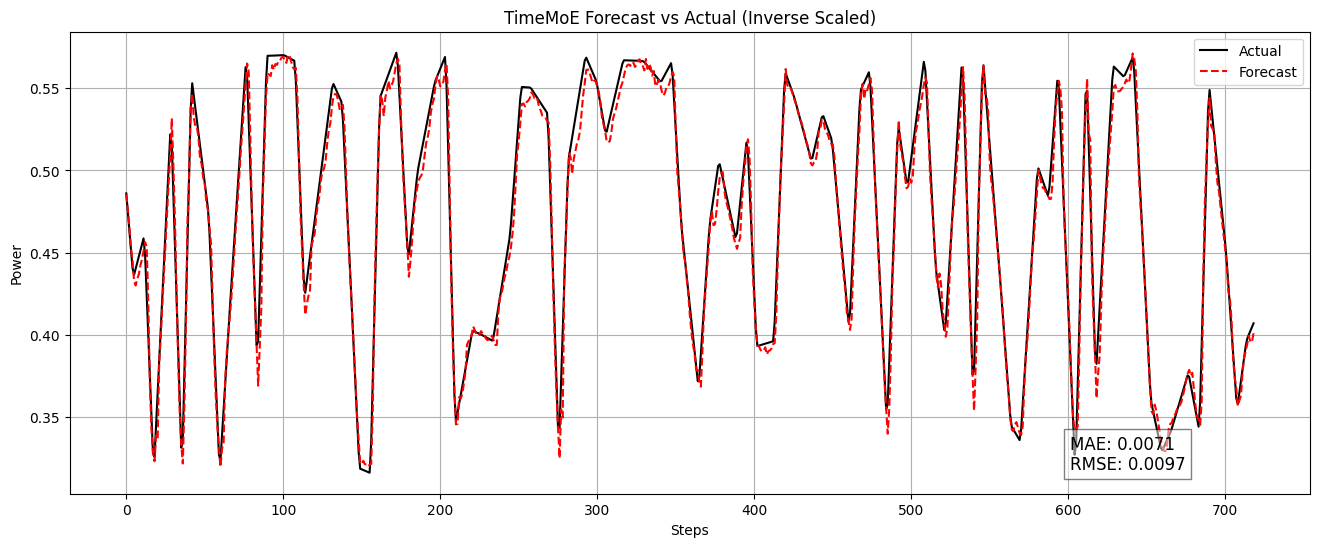

Test MSE: 0.0000, MAE: 0.0048, RMSE: 0.0070


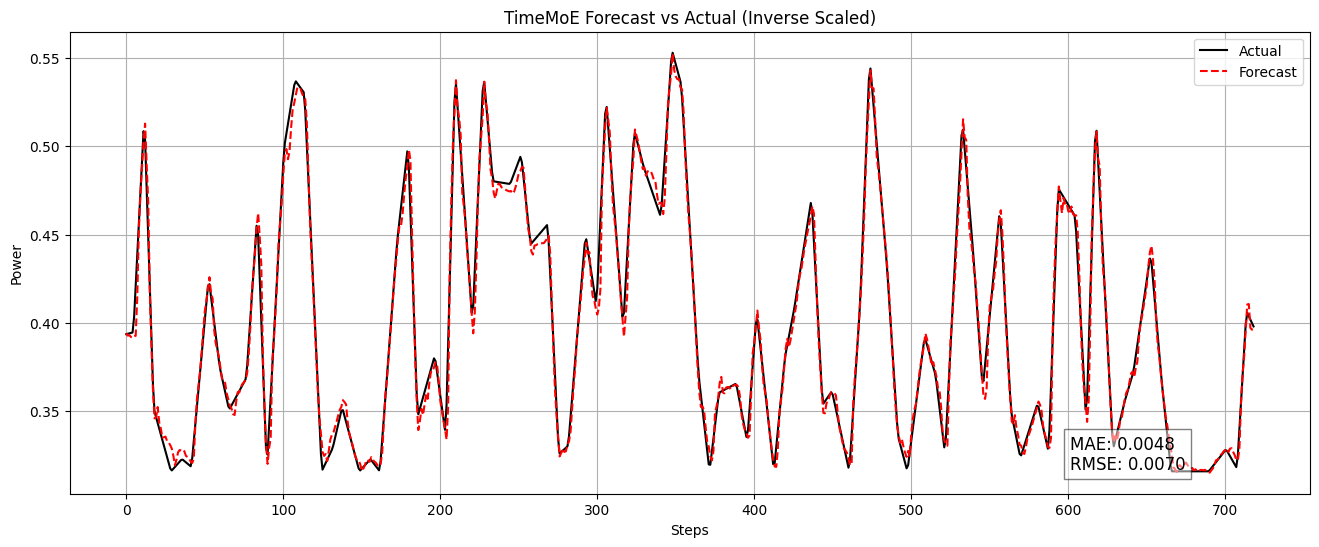

In [22]:
print("\nEvaluating TimeMoE...")

evaluate_timemoe(model_timemoe, scaler_timemoe, X_test, y_test, y_train_org, features, seq_len, start_point=7991, end_point=8734)
evaluate_timemoe(model_timemoe, scaler_timemoe, X_test, y_test, y_train_org, features, seq_len,  start_point=16726, end_point=17469)
evaluate_timemoe(model_timemoe, scaler_timemoe, X_test, y_test, y_train_org, features, seq_len, start_point=25461, end_point=26204)
evaluate_timemoe(model_timemoe, scaler_timemoe, X_test, y_test, y_train_org, features, seq_len, start_point=34196, end_point=34939)

